In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import os

In [2]:


# Directories for training and testing data
train_dir = "Gambo/Train/"
test_dir = "Gambo/Test/"

# Define transforms for the images
# This example converts images to grayscale, resizes them to 28x28, and normalizes the pixel values.
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Remove if images are already grayscale
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjust normalization if needed
])

# Load the datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [3]:
# Define a simple CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Output: [32, 28, 28]
        self.pool = nn.MaxPool2d(2, 2)                           # Output: [32, 14, 14]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Output: [64, 14, 14]
        # After pooling: [64, 7, 7]
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [5]:
# Determine the number of classes from the dataset folder names
num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)

# Set device to GPU if available
device = torch.device("mps" if torch.backends.mps.is_available else "cpu")
print("Device:", device)
model = CNNModel(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Classes: ['Corrected', 'Normal', 'Reversal']
Device: mps


In [6]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/10, Loss: 0.2207
Epoch 2/10, Loss: 0.0998
Epoch 3/10, Loss: 0.0737
Epoch 4/10, Loss: 0.0603
Epoch 5/10, Loss: 0.0511
Epoch 6/10, Loss: 0.0451
Epoch 7/10, Loss: 0.0390
Epoch 8/10, Loss: 0.0354
Epoch 9/10, Loss: 0.0326
Epoch 10/10, Loss: 0.0318


In [7]:
# Evaluate the model on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print evaluation metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))
print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")

Classification Report:
              precision    recall  f1-score   support

   Corrected       0.98      0.92      0.95     19284
      Normal       0.76      0.93      0.84     19557
    Reversal       0.92      0.76      0.83     17882

    accuracy                           0.87     56723
   macro avg       0.89      0.87      0.87     56723
weighted avg       0.88      0.87      0.87     56723

Accuracy: 0.8712


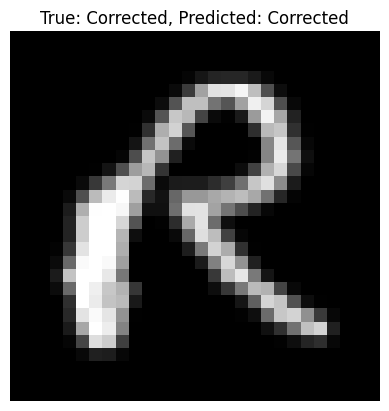

In [8]:
# Visualize a sample prediction from the test set
sample_img, sample_label = test_dataset[0]
model.eval()
with torch.no_grad():
    sample_img_tensor = sample_img.unsqueeze(0).to(device)
    output = model(sample_img_tensor)
    pred = torch.argmax(output, dim=1).item()

plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"True: {train_dataset.classes[sample_label]}, Predicted: {train_dataset.classes[pred]}")
plt.axis('off')
plt.show()